In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [21]:
#assume that vectors of interest are along the last dimension

def softmax(s):
    amax = np.amax(s, axis=0, keepdims=True)
    return amax + np.log(np.sum(np.exp(s - amax), axis=0))

def softargmax(s):
    return np.exp(s - softmax(s))

def hessian(s):
    # only works for 1d input
    p = softargmax(s)
    return np.diag(p) - np.outer(p, p)

def var(p,x):
    average = np.sum(p*x)
    return np.sum(p* x**2) - average**2

def varoperator(p):
    return np.diag(p) - np.outer(p, p)


In [22]:
s = np.random.randn(3)
a = softmax(s)
p = softargmax(s)
H = hessian(s)
print(s)
print(a)
print(p, p.sum())
print(H)
print(np.linalg.det(H[:-1,:-1]))

[ 1.69913704 -0.65562969  0.34953421]
[ 2.0023914]
[ 0.73841125  0.07008678  0.19150197] 1.0
[[ 0.19316008 -0.05175287 -0.14140721]
 [-0.05175287  0.06517462 -0.01342176]
 [-0.14140721 -0.01342176  0.15482897]]
0.00991077597524


In [23]:
spectrum, eigvectors = np.linalg.eigh(H)
print(spectrum)
print("condition number ",spectrum[-1]/spectrum[1])
print(eigvectors)

onevec = eigvectors[:,1]
print(np.dot(np.dot(H, onevec), onevec))
print(var(p, onevec))

[  2.19957516e-17   9.28113375e-02   3.20352327e-01]
condition number  3.45165079815
[[ 0.57735027  0.29948282 -0.75958983]
 [ 0.57735027 -0.8075655   0.12043518]
 [ 0.57735027  0.50808268  0.63915464]]
0.0928113374545
0.0928113374545


In [28]:
from simplex import Simplex

In [29]:
simplex = Simplex()

Simplex with resolution 6: 2145 points.


In [30]:
# study the evolution of the condition number in 3-simplex
def smoothness(probas):
    ans = []
    for proba in probas:
        score = np.log(proba + 1e-12)
        eigenvalues, eigenvectors = np.linalg.eigh(hessian(score))
        ans.append(eigenvalues[-1])

    return np.array(ans)

def volume(probas):
    ans = []
    for proba in probas:
        ans.append(np.linalg.det(varoperator(proba)[:-1,:-1]))

    return np.array(ans)

def log_condition_number(probas, cap=2):
    return np.minimum(np.log10(condition_number(probas)), cap)

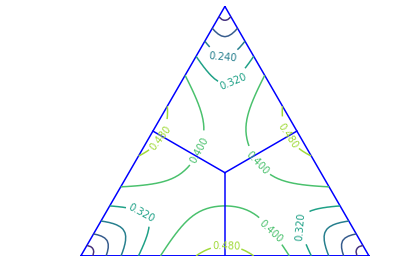

In [31]:
simplex.show_func(smoothness)

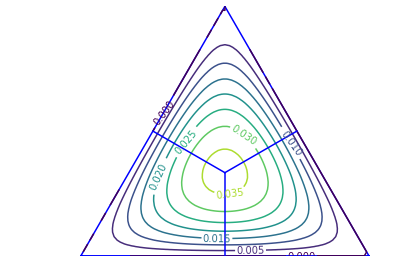

In [32]:
simplex.show_func(volume)

smooth but strongly convex only in a subspace

What are tajectories of gradient descent ? They are straight line in the score space, but what do they look like in the probability space?

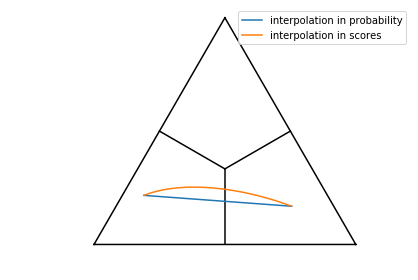

In [135]:
# interpolation line

p1 = 0
p2 = 0
while np.sum((p1-p2)**2) < .3:
    s1 = np.random.randn(3)
    p1 = softargmax(s1)

    s2 = np.random.randn(3)
    p2 = softargmax(s2)
    

interp = np.linspace(0,1,100)[:,np.newaxis]
proba_line = interp*p1 + (1-interp)*p2
score_line = softargmax((interp*s1 + (1-interp)*s2).T).T

# plot
simplex.show_borders(color='black')

cartprobas = simplex.bary2cart(proba_line).T
plt.plot(cartprobas[0], cartprobas[1], label='interpolation in probability')

cartscores = simplex.bary2cart(score_line).T
plt.plot(cartscores[0], cartscores[1], label='interpolation in scores')
plt.legend()
pass

# third order derivative of softmax

The third order gradient $\nabla^3 f(s)$ evaluated at $s$ and applied to $v\otimes v\otimes v$ is equal to the third order cumulant or third order centered moment of $v_i, i\sim p(s) = \nabla f(s)$.

$$\nabla^3 f(s)(v^{\otimes 3}) = E_{i\sim p(s)}\left[(v_i - E[v_j])^3 \right]$$

For a Bernoulliof parameter $p$ ($K=2$) and support $v_+>v_-$ instead of $0,1$, this is written as 

$$p(1-p)(2p-1)(v_+ - v_-)^3$$

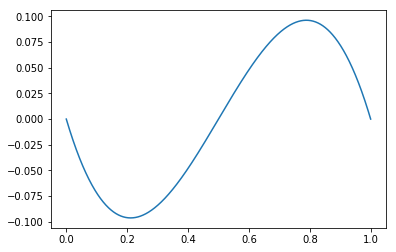

In [141]:
pp = np.linspace(0,1,1000)
skewness = pp*(1-pp)*(2*pp-1)
plt.plot(pp, skewness)

In [150]:
imax = np.argmax(skewness)
print('The max value of third order moment of Bernoulli is {:.2f}={:.2f} reached for p={:.2f}={:.2f}.'
      .format(skewness[imax], .5*3**(-1.5), pp[imax], .5*(1+1/np.sqrt(3))))
print(f'If we add the unit constraint on the support then it is {.5*(2/3)**1.5:.2f}')

The max value of third order moment of Bernoulli is 0.10=0.10 reached for p=0.79=0.79.
If we add the unit constraint on the support then it is 0.27


I make the conjecture that the Hessian of the softmax is 1/3 Lipschitz

# Study the Wishart distribution
The eigenvalues of samples from the inverse wishart can get arbitrarily large when the degree of freedom is equal to the dimension of the scale matrix. This is mitigated by increasing the degree of freedom.

In [28]:
import scipy

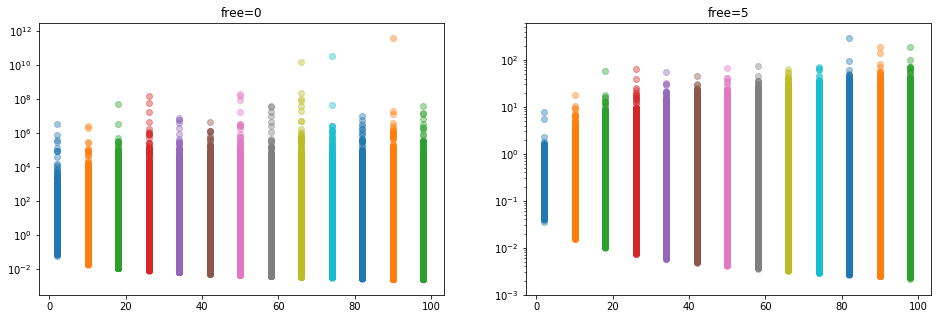

In [30]:
freedoms = [0,5]
dims = np.arange(2,100,8)
fig, axs = plt.subplots(ncols=len(freedoms), figsize=(16,5))
for k, ax in zip(freedoms, axs):
    ax.set_title(f'free={k}')
    ax.set_yscale('log')
    ax.autoscale()
    for dim in range(2,100,8):
        invwish = scipy.stats.invwishart(df=dim+k,scale=np.eye(dim))
        sam = invwish.rvs(100)
        val, _ = np.linalg.eigh(sam)
        val = val.flatten()
        ax.scatter(dim*np.ones_like(val), val, alpha=.4)

# Expected distance for categorical distributions


In [3]:
import distances
from distances import categorical_distances_cause, categorical_distances_effect, gaussian_distances
kk = np.arange(2, 100, 5)

def compute_distances(distfunc, n = 100):
    dist = []
    for k in kk:
        dist.append(distfunc(k,n))

    return np.array(dist)

In [22]:
def compute_percentile(dist):
    quart1 = np.percentile(dist,5, axis=1)
    median = np.median(dist, axis=1)
    quart3 = np.percentile(dist,95, axis=1)
    return median, quart1, quart3

In [5]:
def categoricaldist(k,n):
    return categorical_distances_cause(k,n,concentration=1)


dist = compute_distances(categoricaldist)
median,quart1,quart3 = compute_percentile(dist)

In [233]:
bscoresdistance = dist[:,:,7]
print(bscoresdistance.mean())
print(bscoresdistance.std())

0.058511247279
0.091906516693


In [234]:
def plot6categ(quart1,median,quart3,intervention):

    def plotfill(ax,index,label):
        ax.plot(kk,median[:,index], label=label)
        ax.fill_between(kk, quart1[:,index], quart3[:,index], alpha=0.3)
        ax.set_title(label)
        ax.grid()

    fig, axs = plt.subplots(2,3, figsize=(16,10))
    plotfill(axs[0,0], 0, 'proba causal')
    plotfill(axs[0, 1], 1, 'proba anticausal')
    plotfill(axs[0, 1], 6, 'proba anticausal')
    plotfill(axs[0,2], 2, 'ratio anticausal/causal')

    slope = np.median(median[:,3]/kk)
    axs[1, 0].plot(kk,kk*slope, label='line fit',color='orange')
    plotfill(axs[1, 0], 3, f'scores causal - slope={slope:.2f}')

    sqcoeff = np.median(median[:,4]/kk**2)
    axs[1,1].plot(kk,kk**2 * sqcoeff, label='quadratic fit', color='orange')
    plotfill(axs[1, 1], 4, f'scores anticausal - coeff={sqcoeff:.2f}')
    plotfill(axs[1, 1], 7, f'scores anticausal - coeff={sqcoeff:.2f}')

    plotfill(axs[1,2], 5, 'ratio anticausal/causal')

    plt.savefig(f'categorical_distances_{intervention}.pdf')

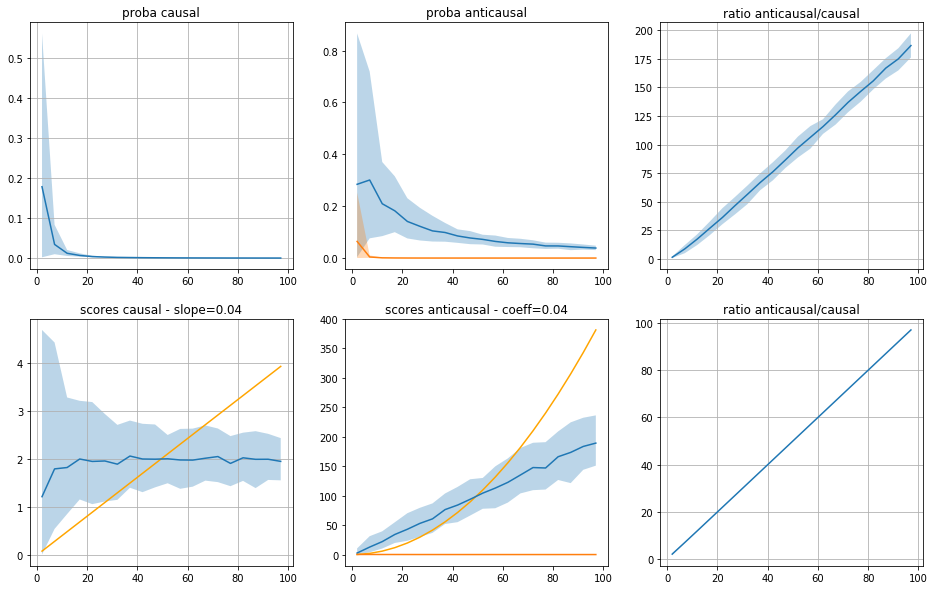

In [235]:
plot6categ(quart1, median, quart3, 'cause')

In [239]:
def categeffect(k,n):
    return categorical_distances_effect(k, n, concentration=1)

dist = compute_distances(categeffect)
median,quart1,quart3 = compute_percentile(dist)

In [240]:
median[:,7]*kk

array([  0.99938209,   6.24541848,  11.95112371,  16.5889896 ,
        21.30616082,  26.61878161,  32.05117543,  38.17286864,
        42.8573935 ,  48.59621842,  52.41471755,  58.28637979,
        63.82547875,  65.47554484,  71.26715262,  78.02185963,
        81.56299907,  86.27603263,  93.62508806,  97.28626048])

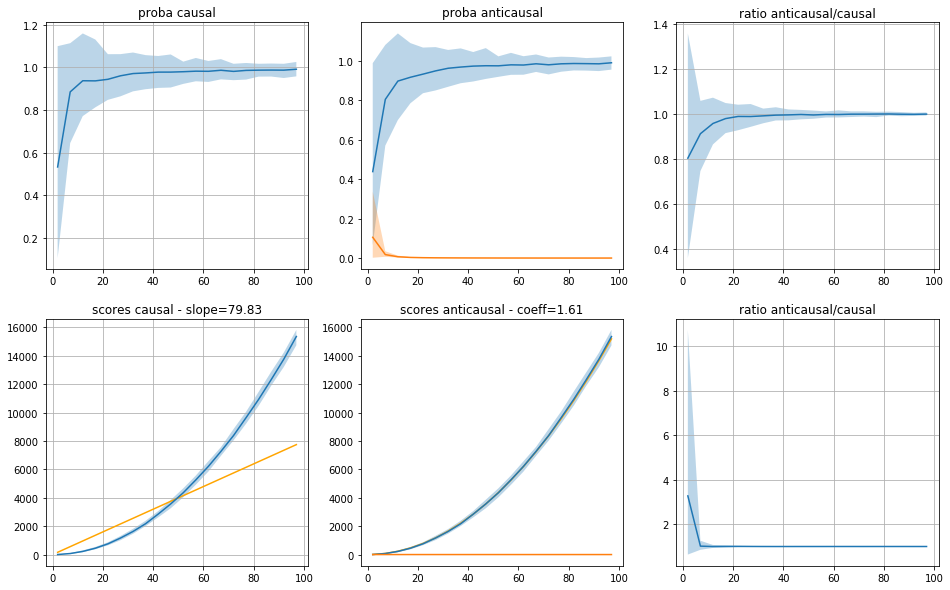

In [241]:
plot6categ(quart1, median, quart3, 'effect')

The expected distance between the current and optimal causal scores grows linearly with the size of the distribution support. For the anticausal scores, it grows quadratically. Both causal and anticausal distances have the same leading coefficient which decreases with the concentration of the Dirichlet distribution.

Actually we can prove that 

$$\|s(A|B) - \tilde s(A|B)\|^2 = K \|s(A) - \tilde s(A)\|^2 $$

which explains the shape of the curve on the right with a negligible influence of the distance $\|s(B) - \tilde s(B)\|^2$.

# Expected distance for Gaussian distributions

In [10]:
import distances
zizi = distances.ConditionalGaussian.random(10)


In [11]:
def gaussiancausedist(k,n):
    return gaussian_distances(k,n,intervention='cause', symmetric=True)


def gaussianeffectdist(k,n):
    return gaussian_distances(k,n,intervention='effect', symmetric=True)

In [12]:
def plot6(quart1,median,quart3,intervention):
    
    def plotfill(ax,index,label):
        ax.plot(kk,median[:,index], label=label)
        ax.fill_between(kk, quart1[:,index], quart3[:,index], alpha=0.3)
        ax.set_title(label)
        ax.set_yscale('log')
        ax.grid()

    fig, axs = plt.subplots(2,3, figsize=(16,10))
    plotfill(axs[0,0], 0, 'mean causal')
    plotfill(axs[0, 1], 1, 'mean anticausal')
    plotfill(axs[0,2], 2, 'ratio anticausal/causal')

    plotfill(axs[1, 0], 3, f'natural causal')
    plotfill(axs[1, 1], 4, f'natural anticausal')
    plotfill(axs[1,2], 5, 'ratio anticausal/causal')

    plt.savefig(f'gaussian_distances_intervene_{intervention}.pdf')

In [23]:
gausscausdist = compute_distances(gaussiancausedist, n=300)
median,quart1,quart3 = compute_percentile(gausscausdist)

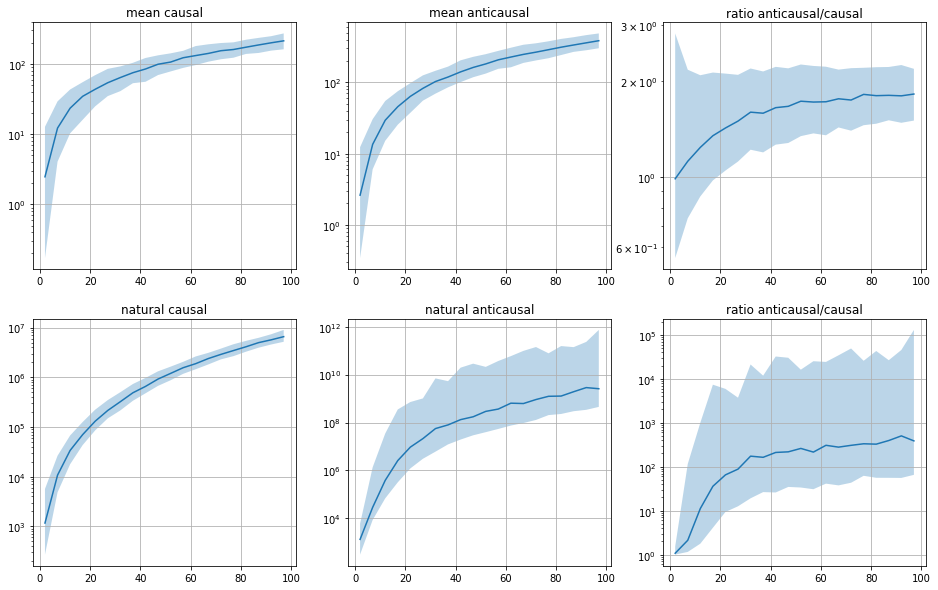

In [24]:
plot6(quart1,median,quart3, 'cause_symmetric')

In [25]:
gausseffectdist = compute_distances(gaussianeffectdist, n=300)
median,quart1,quart3 = compute_percentile(gausseffectdist)

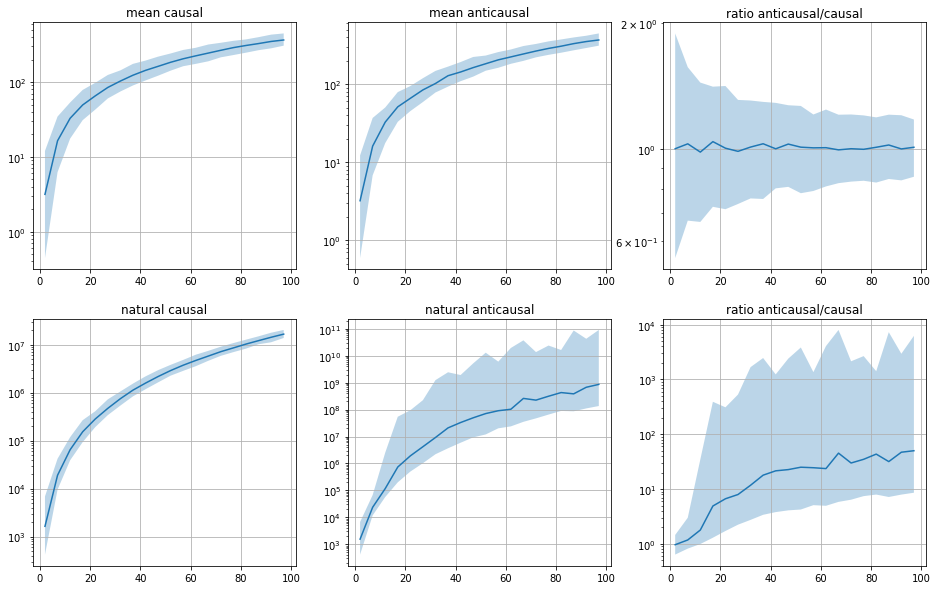

In [26]:
plot6(quart1,median,quart3, 'effect_symmetric')